In [2]:
# TODO - NYU Depth V2:
# The NYU-Depth V2 data set is comprised of video sequences from a variety of
# indoor scenes as recorded by both the RGB and Depth cameras from the Microsoft
# Kinect. It features:
#   - 1449 densely labeled pairs of aligned RGB and depth images
#   - 464 new scenes taken from 3 cities
#   - 407,024 new unlabeled frames
#   - Each object is labeled with a class and an instance number (cup1, cup2, cup3, etc)
# The dataset has several components:
#   - Labeled: A subset of the video data accompanied by dense multi-class labels.
#            This data has also been preprocessed to fill in missing depth labels.
#   - Raw: The raw RGB, depth, and accelerometer data as provided by the Kinect.
# Toolbox: Useful functions for manipulating the data and labels.
import imp
import time
import numpy as np
import pandas as pd
import scipy.io as sci  # this is the SciPy module that loads mat-files
import matplotlib.pyplot as plt
from datetime import datetime, date

from google.colab import drive
drive.mount('/content/drive')

def downloader_to_gdrive(link, base_path, file_name, zip=False):
  path = base_path + file_name
  import os
  isdir = os.path.isdir(path[:-4])
  if isdir:
    print(file_name[:-4], "folder already exists! Download skipped...\n")
  else:
    isFile = os.path.isfile(path)
    if isFile:
      print(file_name, "already exists! Download skipped...\n")
    else:
      import requests
      r = requests.get(link, stream = True)
      # 1 MB = 1024 * 1024 byte
      CS = 5000*1024*1024
      with open(path, "wb") as file: 
        print(file_name, "download started.")
        for i, block in enumerate(r.iter_content(chunk_size = CS)):
          # print(".", end = "")
          # print((i+1)*chunk_size,"MB downloaded...")
          file.write(block)
          # if block:
        print("\n" + file_name, "download finished.")
    if zip:
      print("Extracting started...")
      import zipfile
      with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(path[:-4])
      print("Extracting finished...\n")

base_path = "/content/drive/MyDrive/"
nyu_dep_name = "nyu_depth_v2_labeled.mat"
nyu_dep_link = "http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat"
downloader_to_gdrive(nyu_dep_link, base_path, nyu_dep_name)

nyu_dep_path = base_path + nyu_dep_name

import h5py
f = h5py.File(nyu_dep_path,'r')
nyu_dict = {}
t = time.time()
print("Shapes:")
for key, value in f.items():
  nyu_dict[key] = np.array(value)
  print("  {:18s} {}".format(key+":", nyu_dict[key].shape))
print("\ndataset loaded in {} seconds!\n".format(str(int(time.time()-t))))

Mounted at /content/drive
nyu_depth_v2_labeled.mat already exists! Download skipped...

Shapes:
  #refs#:            (8484,)
  #subsystem#:       (1,)
  accelData:         (4, 1449)
  depths:            (1449, 640, 480)
  images:            (1449, 3, 640, 480)
  instances:         (1449, 640, 480)
  labels:            (1449, 640, 480)
  names:             (1, 894)
  namesToIds:        (1, 6)
  rawDepthFilenames: (1, 1449)
  rawDepths:         (1449, 640, 480)
  rawRgbFilenames:   (1, 1449)
  sceneTypes:        (1, 1449)
  scenes:            (1, 1449)

dataset loaded in 91 seconds!



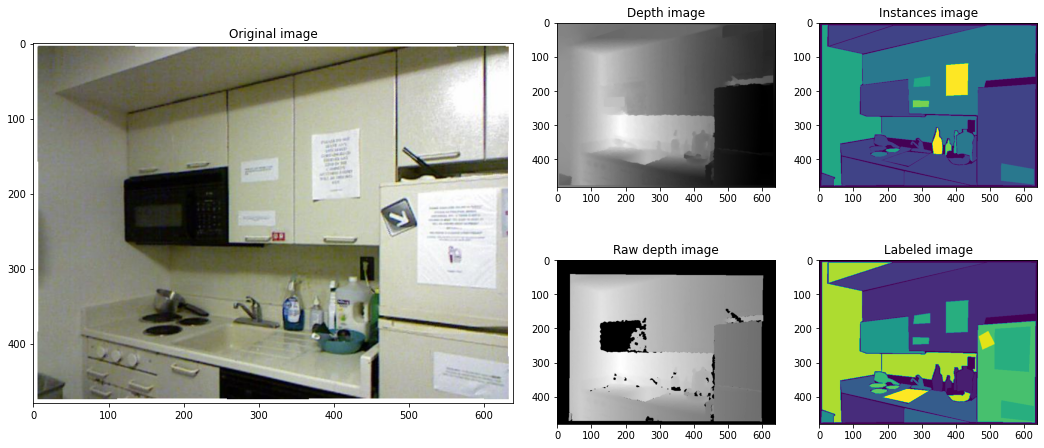

In [3]:
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
org_images = nyu_dict["images"].transpose((0,3,2,1))
dep_images = nyu_dict["depths"].transpose((0,2,1))
raw_images = nyu_dict["rawDepths"].transpose((0,2,1))
ins_images = nyu_dict["instances"].transpose((0,2,1))
lbl_images = nyu_dict["labels"].transpose((0,2,1))

# Plot a sample image:
fig, axarr = plt.subplots(2,4, figsize=(18,8))
# Plot RGB image:
axarr[0,0] = plt.subplot2grid(shape=(2, 4), loc=(0, 0), colspan=2, rowspan=2)
axarr[0,0].set_title('Original image')
axarr[0,0].imshow(org_images[1])
# Plot depth image:
axarr[0,2].set_title('Depth image')
axarr[0,2].imshow(dep_images[1], cmap=plt.get_cmap('gray'))
# Plot raw depth image:
axarr[1,2].set_title('Raw depth image')
axarr[1,2].imshow(raw_images[1], cmap=plt.get_cmap('gray'))
# Plot instances image:
axarr[0,3].set_title('Instances image')
axarr[0,3].imshow(ins_images[1])
# Plot labeled image:
axarr[1,3].set_title('Labeled image')
axarr[1,3].imshow(lbl_images[1])

In [4]:
import os
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split

t = time.time()
train_rgb, test_rgb = train_test_split(org_images, test_size=0.2, shuffle=False)
train_dep, test_dep = train_test_split(dep_images, test_size=0.2, shuffle=False)
print("Test data size:", len(test_rgb))
print("Train data size:", len(train_rgb))

# Save all train images to use for learning:
tr_dir = "train_images"
if not os.path.exists(tr_dir):
  os.mkdir(tr_dir)
t = time.time()
for i, img in enumerate(train_rgb):
  im = Image.fromarray(img)
  im.save(tr_dir + "/rgb_" + str(i) + ".jpg")
  I = train_dep[i]
  I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)
  dep_im = Image.fromarray(I8)
  dep_im.save(tr_dir + "/dep_" + str(i) + ".jpg")
print("All the train images saved on {} directory in {} seconds!".format(tr_dir, str(int(time.time()-t))))

# Save all train images to use for learning:
te_dir = "test_images"
if not os.path.exists(te_dir):
  os.mkdir(te_dir)
t = time.time()
for i, img in enumerate(test_rgb):
  im = Image.fromarray(img)
  im.save(te_dir + "/rgb_" + str(i) + ".jpg")
  I = test_dep[i]
  I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)
  dep_im = Image.fromarray(I8)
  dep_im.save(te_dir + "/dep_" + str(i) + ".jpg")
print("All the test images saved on {} directory in {} seconds!".format(te_dir, str(int(time.time()-t))))

Test data size: 290
Train data size: 1159
All the train images saved on train_images directory in 29 seconds!
All the test images saved on test_images directory in 8 seconds!


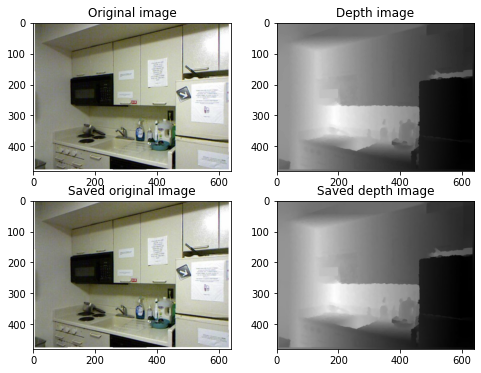

In [ ]:
import cv2
# Picture to check
id = 1
# Plot a sample image:
fig, axarr = plt.subplots(2,2, figsize=(8,6))
# Plot RGB image:
axarr[0,0].set_title('Original image')
axarr[0,0].imshow(train_rgb[id])
# Plot depth image:
axarr[0,1].set_title('Depth image')
axarr[0,1].imshow(train_dep[id], cmap=plt.get_cmap('gray'))
# Plot saved RGB image:
axarr[1,0].set_title('Saved original image')
axarr[1,0].imshow(cv2.cvtColor(cv2.imread(tr_dir+"/rgb_" + str(id) + ".jpg"), cv2.COLOR_BGR2RGB))
# Plot saved depth image:
axarr[1,1].set_title('Saved depth image')
axarr[1,1].imshow(cv2.cvtColor(cv2.imread(tr_dir+"/dep_" + str(id) + ".jpg"), cv2.COLOR_BGR2RGB), cmap=plt.get_cmap('gray'))

!! Run next cell **ONLY** If you want to remove all the saved files and their folder !!

In [ ]:
import shutil
shutil.rmtree(tr_dir)
shutil.rmtree(te_dir)

# Depth Estimation:

!! Limited RAM problem !! <br/>
!! RESTART RUNTIME HERE !! <br/>
then start the rest of the code.<br/>
we have the saved files on the folders.<br/>
so we should free up the memory.

In [ ]:
import gc
import cv2
import time
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Normal the input images:
normalizer = lambda input_image: (input_image / 255)
# Reshape the input images using tensorflow:
tf_resizer = lambda input_image: tf.image.resize(input_image, [128, 128], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
# Reshape the input images using openCV:
resizer = lambda input_image: cv2.resize(input_image, (128, 128))

t = time.time()
tr_dir = "train_images"
images_dataset = []
depths_dataset = []
for id in tqdm([i for i in range(round(1449 * 0.8))]):
  # RGB images:
  rgb = cv2.imread(tr_dir + "/rgb_" + str(id) + ".jpg")
  rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
  rgb = normalizer(rgb)
  rgb = resizer(rgb)
  images_dataset.append(rgb)
  # Depth images:
  dep = cv2.imread(tr_dir + "/dep_" + str(id) + ".jpg")
  dep = cv2.cvtColor(dep, cv2.COLOR_BGR2RGB)
  dep = dep - dep.min()
  dep = dep / dep.max() 
  dep = resizer(dep)
  depths_dataset.append(dep)

images_dataset = np.array(images_dataset)
depths_dataset = np.array(depths_dataset)
print("Train images prepared for training in {} seconds!".format(str(int(time.time()-t))))
print("\nGarbage collector:")
gc.collect()

  0%|          | 0/1159 [00:00<?, ?it/s]

Train images prepared for training in 15 seconds!

Garbage collector:


20672

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.keras import Model
from tensorflow.keras import layers

# Decoder (Downsampler):
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
  if apply_batchnorm:
    result.add(layers.BatchNormalization())
  result.add(layers.LeakyReLU(alpha=0.3))
  return result

# Encoder (Upsampler):
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
  result.add(layers.BatchNormalization())
  if apply_dropout:
    result.add(layers.Dropout(0.5))
  result.add(layers.ReLU())
  return result

# U-Net Model:
def unet(input_shape, output_shape, activation='sigmoid'):
  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    # downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]
  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    # upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  inputs = layers.Input(shape=input_shape)
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  
  skips = reversed(skips[:-1])
  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = layers.Concatenate()([x, skip])

  init = tf.random_normal_initializer(0., 0.02)
  last = layers.Conv2DTranspose(output_shape, 4, strides=2, padding='same', kernel_initializer=init, activation=activation)  # (batch_size, 256, 256, 3)
  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

TensorFlow version: 2.7.0


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

ep_count = 60
bs = 64
opt = tf.keras.optimizers.Adam(learning_rate = 0.0009)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
estimator = unet(input_shape=[128, 128, 3], output_shape=1, activation='sigmoid')
estimator.compile(optimizer=opt, loss=tf.keras.losses.Huber(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

# tf.keras.utils.plot_model(estimator, show_shapes=True, dpi=64)

t = time.time()
es_history = estimator.fit(images_dataset, depths_dataset, epochs = ep_count, batch_size=bs, validation_split=0.2, shuffle=True)
print("Learning time:", time.time()-t)

Epoch 1/60
15/15 [==============================] - 13s 568ms/step - loss: 0.0329 - mean_absolute_error: 0.2173 - val_loss: 0.0337 - val_mean_absolute_error: 0.2226
Epoch 2/60
15/15 [==============================] - 5s 341ms/step - loss: 0.0272 - mean_absolute_error: 0.1944 - val_loss: 0.0488 - val_mean_absolute_error: 0.2580
Epoch 3/60
15/15 [==============================] - 5s 344ms/step - loss: 0.0263 - mean_absolute_error: 0.1892 - val_loss: 0.0441 - val_mean_absolute_error: 0.2440
Epoch 4/60
15/15 [==============================] - 5s 347ms/step - loss: 0.0250 - mean_absolute_error: 0.1838 - val_loss: 0.0985 - val_mean_absolute_error: 0.3801
Epoch 5/60
15/15 [==============================] - 5s 348ms/step - loss: 0.0234 - mean_absolute_error: 0.1769 - val_loss: 0.0899 - val_mean_absolute_error: 0.3590
Epoch 6/60
15/15 [==============================] - 5s 350ms/step - loss: 0.0216 - mean_absolute_error: 0.1689 - val_loss: 0.0900 - val_mean_absolute_error: 0.3606
Epoch 7/60
15/1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


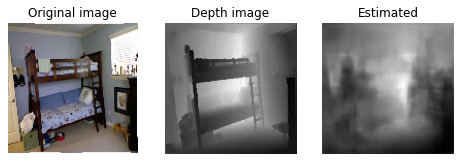

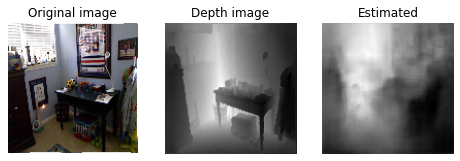

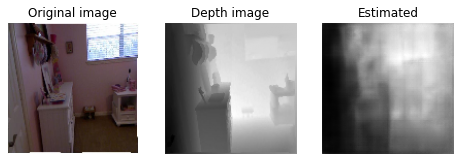

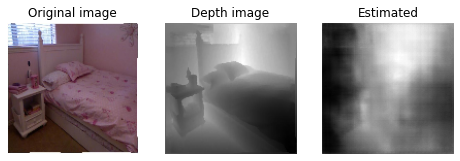

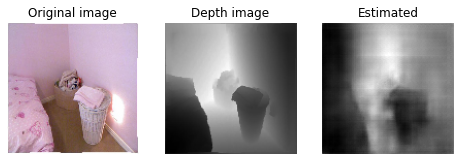

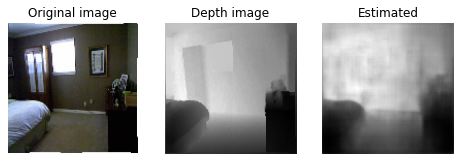

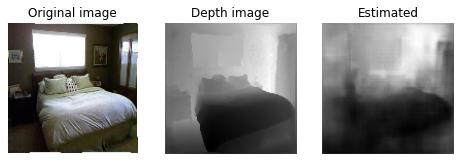

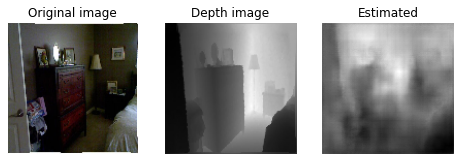

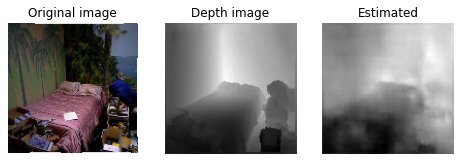

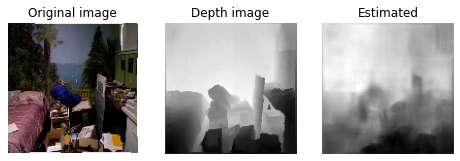

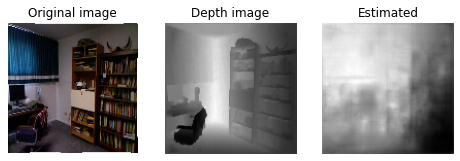

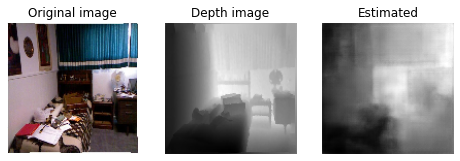

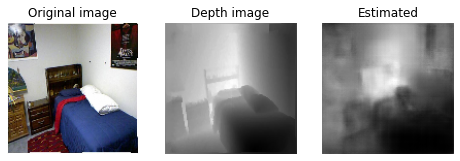

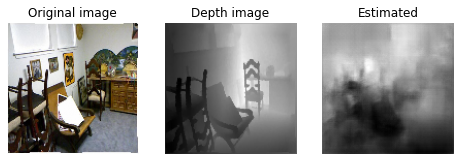

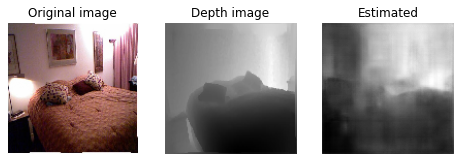

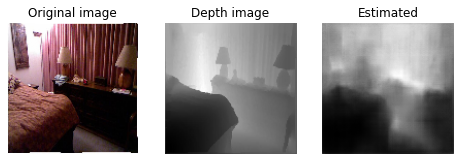

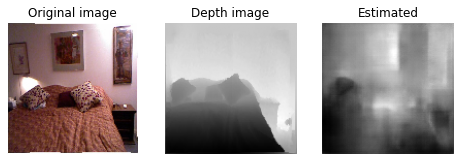

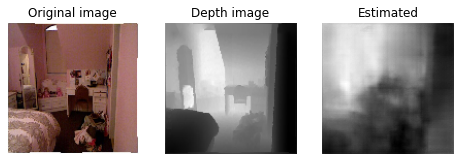

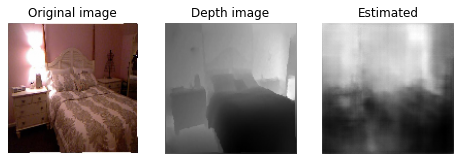

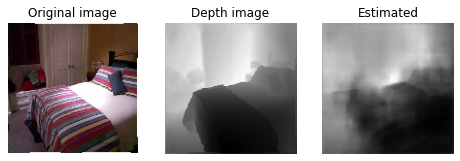

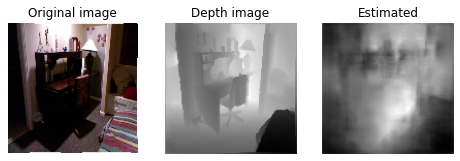

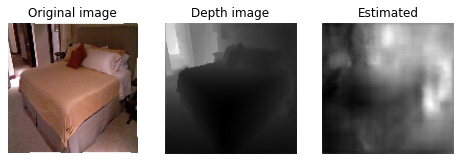

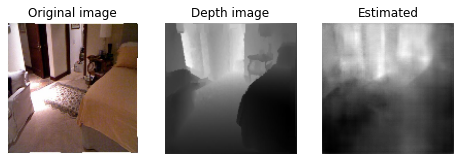

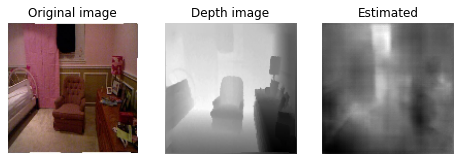

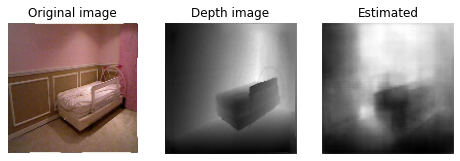

In [ ]:
te_dir = "test_images"
for id in range(25):
  rgb = cv2.imread(te_dir + "/rgb_" + str(id) + ".jpg")
  rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
  rgb = normalizer(rgb)
  rgb = resizer(rgb)
  es_output = estimator(rgb[tf.newaxis, ...], training=False)

  dep = cv2.imread(te_dir + "/dep_" + str(id) + ".jpg")
  dep = cv2.cvtColor(dep, cv2.COLOR_BGR2RGB)
  dep = dep - dep.min()
  dep = dep / dep.max() 
  dep = resizer(dep)

  # Plot a sample image:
  fig, axarr = plt.subplots(1,3, figsize=(8,6))
  # Plot RGB image:
  axarr[0].set_title("Original image")
  axarr[0].axis('off')
  axarr[0].imshow(rgb)
  # Plot depth image:
  axarr[1].set_title('Depth image')
  axarr[1].axis('off')
  axarr[1].imshow(dep, cmap=plt.get_cmap('gray'))
  # Plot depth image:
  axarr[2].set_title('Estimated')
  axarr[2].axis('off')
  axarr[2].imshow(np.array(es_output[0]).reshape(128, 128), cmap=plt.get_cmap('gray'))

Saving model:

In [ ]:
import zipfile
import shutil

name_of_model = "estimator_model"
zip_file_name = name_of_model + ".zip"
h5_file_name = name_of_model + ".h5"
save_to_drive = True

# saving the model:
estimator.save(h5_file_name)

# Compressing:
with zipfile.ZipFile(zip_file_name,'w', zipfile.ZIP_DEFLATED, compresslevel=9) as zip:
  zip.write(h5_file_name)

# Transfer zipped file:
if save_to_drive:
  from google.colab import drive
  drive.mount('/content/drive')
  shutil.copyfile(zip_file_name, "/content/drive/MyDrive/" + zip_file_name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


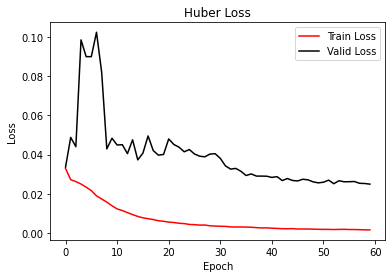

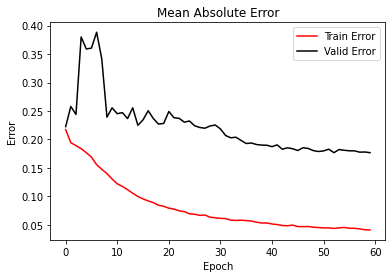

In [ ]:
import matplotlib.pyplot as plt

plt.plot(es_history.history['loss'], 'r-', label='Train Loss')
plt.plot(es_history.history['val_loss'], 'k-', label='Valid Loss')
plt.title('Huber Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(es_history.history['mean_absolute_error'], 'r-', label='Train Error')
plt.plot(es_history.history['val_mean_absolute_error'], 'k-', label='Valid Error')
plt.legend()
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

# Object Detection:

If we have our pictures folder ready to use, it's better to restart runtime here.

[INFO] loading YOLO from disk...
[INFO] YOLO took 2.137444 seconds!


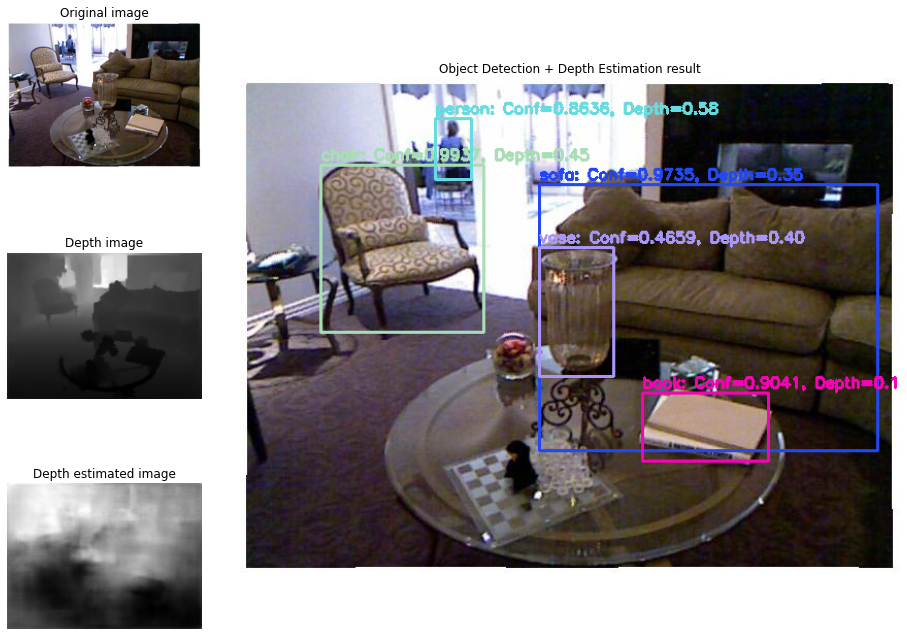

In [7]:
from PIL import Image
import urllib.request
import numpy as np
import time
import os
import cv2
import shutil
import zipfile
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Define Paths:
# yolo model folder:
yolo_base_path = "yolo-coco"
weights_Path = yolo_base_path + "/yolov3.weights"
config_Path = yolo_base_path + "/yolov3.cfg"
labels_Path = yolo_base_path + "/coco.names"

accepted_confidence = 0.3
threshold = 0.3

load_from_drive = True
name_of_model = "estimator_model"
zip_file_name = name_of_model + ".zip"
h5_file_name = name_of_model + ".h5"

# Download to colab:
def temporary_downloader(path, link):
  urllib.request.urlretrieve(link, path)

# Create yolo model folder and download files:
if not os.path.exists(yolo_base_path):
  os.mkdir(yolo_base_path)
# download yolov3.cfg
if not os.path.isfile(config_Path):
  temporary_downloader(config_Path, "https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg")
# download yolov3.weights
if not os.path.isfile(weights_Path):
  temporary_downloader(weights_Path, "https://pjreddie.com/media/files/yolov3.weights")
# download coco.names
if not os.path.isfile(labels_Path):
  temporary_downloader(labels_Path, "https://raw.githubusercontent.com/pjreddie/darknet/a028bfa0da8eb96583c05d5bd00f4bfb9543f2da/data/coco.names")
# load the COCO class labels our YOLO model was trained on
LABELS = open(labels_Path).read().strip().split("\n")
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(config_Path, weights_Path)

# load our input image and grab its spatial dimensions
# Image to test:
id = 50
te_dir = "test_images"
rgb = cv2.imread(te_dir + "/rgb_" + str(id) + ".jpg")
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
rgb_display = np.copy(rgb)
(H, W) = rgb.shape[:2]
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
if net.getUnconnectedOutLayers().ndim == 1:
  ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]
else:
  ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(rgb, 1 / 255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)

t = time.time()
layerOutputs = net.forward(ln)
print("[INFO] YOLO took {:.6f} seconds!".format(time.time() - t))

# initialize
boxes = []
confidences = []
classIDs = []
# loop over each of the layer outputs
for output in layerOutputs:
  # loop over each of the detections
  for detection in output:
    scores = detection[5:]
    classID = np.argmax(scores)
    confidence = scores[classID]
		# filter out weak predictions by ensuring the detected probability is greater than the minimum probability
    # extract the class ID and confidence (i.e., probability) of the current object detection
    if confidence > accepted_confidence:
      # scale the bounding box coordinates back relative to the size of the image, keeping in mind that YOLO actually
      # returns the center (x, y)-coordinates of the bounding box followed by the boxes' width and height
      box = detection[0:4] * np.array([W, H, W, H])
      (centerX, centerY, width, height) = box.astype("int")
      # use the center (x, y)-coordinates to derive the top and and left corner of the bounding box
      x = int(centerX - (width / 2))
      y = int(centerY - (height / 2))
      # update our list of bounding box coordinates, confidences and class IDs
      boxes.append([x, y, int(width), int(height)])
      confidences.append(float(confidence))
      classIDs.append(classID)

# apply non-maxima suppression to suppress weak, overlapping bounding boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence, threshold)

# ESTIMATOR output:
# load trained model:
if not os.path.isfile(h5_file_name):
  if load_from_drive:
    from google.colab import drive
    drive.mount('/content/drive')
    shutil.copyfile("/content/drive/MyDrive/" + zip_file_name, zip_file_name)
    with zipfile.ZipFile(zip_file_name) as zf:
      zf.extractall("/content")

estimator = keras.models.load_model(h5_file_name)

# Normal the input images:
normalizer = lambda input_image: (input_image / 255)
# Reshape the input images using tensorflow:
tf_resizer = lambda input_image: tf.image.resize(input_image, [128, 128], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
# Reshape the input images using openCV:
resizer = lambda input_image: cv2.resize(input_image, (128, 128))

te_dir = "test_images"
# prepare RGB image for estimation:
rgb_in = normalizer(rgb)
rgb_in = resizer(rgb_in)
# prepare depth image for displaying:
dep = cv2.imread(te_dir + "/dep_" + str(id) + ".jpg")
dep = cv2.cvtColor(dep, cv2.COLOR_BGR2RGB)
dep = dep - dep.min()
dep = dep / dep.max()
dep = resizer(dep)
# Estimation of depth
es_out = estimator(rgb_in[tf.newaxis, ...], training=False)
es_out = cv2.resize(np.array(es_out).reshape(128, 128), (rgb.shape[1], rgb.shape[0]))
dep_display = cv2.resize(dep, (rgb.shape[1], rgb.shape[0]))


# ensure at least one detection exists
if len(idxs) > 0:
  # loop over the indexes we are keeping
  for i in idxs.flatten():
    # extract the bounding box coordinates
    (x, y) = (boxes[i][0], boxes[i][1])
    (w, h) = (boxes[i][2], boxes[i][3])
    es_box_mean = np.mean(es_out[y:y+h, x:x+w])
    # draw a bounding box rectangle and label on the image
    color = [int(c) for c in COLORS[classIDs[i]]]
    cv2.rectangle(rgb, (x, y), (x + w, y + h), color, 2)
    text = "{}: Conf={:.4f}, Depth={:.2f}".format(LABELS[classIDs[i]], confidences[i], es_box_mean)
    cv2.putText(rgb, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Plot a sample image:
fig, axarr = plt.subplots(3,4, figsize=(16,12))
# Plot RGB image:
axarr[0,0].set_title('Original image')
axarr[0,0].axis('off')
axarr[0,0].imshow(rgb_display)
# Plot depth image:
axarr[1,0].set_title('Depth image')
axarr[1,0].axis('off')
axarr[1,0].imshow(dep_display, cmap=plt.get_cmap('gray'))
# Plot depth estimated image:
axarr[2,0].set_title('Depth estimated image')
axarr[2,0].axis('off')
axarr[2,0].imshow(es_out, cmap=plt.get_cmap('gray'))
# Plot result image:
axarr[0,1] = plt.subplot2grid(shape=(3, 4), loc=(0, 1), rowspan=3, colspan=3)
axarr[0,1].set_title('Object Detection + Depth Estimation result')
axarr[0,1].axis('off')
axarr[0,1].imshow(rgb)